In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import random

In [2]:
datagen = ImageDataGenerator(rescale=1./255)

In [3]:
import os
import shutil
Image_folder = "../Data/Orientation/Data/deadlift/"
train_folder = "../Data/Orientation/Data/train"
valid_folder = "../Data/Orientation/Data/valid"
anomaly_folder = "../Data/Orientation/anomaly"

In [4]:
train_generator = datagen.flow_from_directory(
    directory=train_folder,
    target_size=(256,256),
    batch_size=4,
    class_mode="input",
    shuffle=True,
    seed=42
)

valid_generator = datagen.flow_from_directory(
    directory=valid_folder,
    target_size=(256,256),
    batch_size=4,
    class_mode="input",
    shuffle=True,
    seed=42
)

anomaly_generator = datagen.flow_from_directory(
    directory=anomaly_folder,
    target_size=(256,256),
    batch_size=4,
    class_mode="input",
    shuffle=True,
    seed=42
)


Found 199 images belonging to 1 classes.
Found 50 images belonging to 1 classes.
Found 45 images belonging to 1 classes.


In [5]:
model = Sequential()

# encoder
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=(256,256, 3)))#, input_shape=(256,256, 3)
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))
model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D((2, 2), padding='same'))


#Decoder

model.add(Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(3, (3, 3), activation='sigmoid', padding='same'))

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
model.summary()

2023-08-22 16:06:17.695569: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2023-08-22 16:06:17.695624: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2023-08-22 16:06:17.695638: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2023-08-22 16:06:17.696179: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-22 16:06:17.696507: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 128, 128, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 32, 32, 16)        0

In [425]:
history = model.fit(
        train_generator,
        epochs=500,
        validation_data=valid_generator)

Epoch 1/500
50/50 [==============================] - 3s 57ms/step - loss: 0.0976 - mse: 0.0976 - val_loss: 0.0616 - val_mse: 0.0616
Epoch 2/500
50/50 [==============================] - 3s 54ms/step - loss: 0.0532 - mse: 0.0532 - val_loss: 0.0522 - val_mse: 0.0522
Epoch 3/500
50/50 [==============================] - 3s 55ms/step - loss: 0.0466 - mse: 0.0466 - val_loss: 0.0466 - val_mse: 0.0466
Epoch 4/500
50/50 [==============================] - 3s 54ms/step - loss: 0.0429 - mse: 0.0429 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 5/500
50/50 [==============================] - 3s 55ms/step - loss: 0.0398 - mse: 0.0398 - val_loss: 0.0404 - val_mse: 0.0404
Epoch 6/500
50/50 [==============================] - 3s 55ms/step - loss: 0.0374 - mse: 0.0374 - val_loss: 0.0382 - val_mse: 0.0382
Epoch 7/500
50/50 [==============================] - 3s 55ms/step - loss: 0.0354 - mse: 0.0354 - val_loss: 0.0374 - val_mse: 0.0374
Epoch 8/500
50/50 [==============================] - 3s 55ms/step - loss: 0.

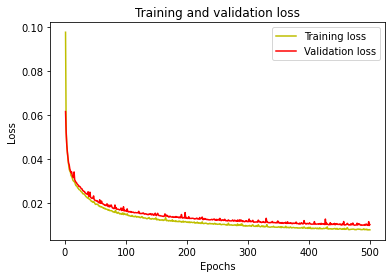

In [426]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [427]:
# Get all batches generated by the datagen and pick a batch for prediction
#Just to test the model. 
data_batch = []  #Capture all training batches as a numpy array
img_num = 0
while img_num <= anomaly_generator.batch_index:   #gets each generated batch of size batch_size
    data = anomaly_generator.next()
    data_batch.append(data[0])
    img_num = img_num + 1

predicted = model.predict(data_batch[0])  #Predict on the first batch of images



1/1 [==============================] - 0s 66ms/step


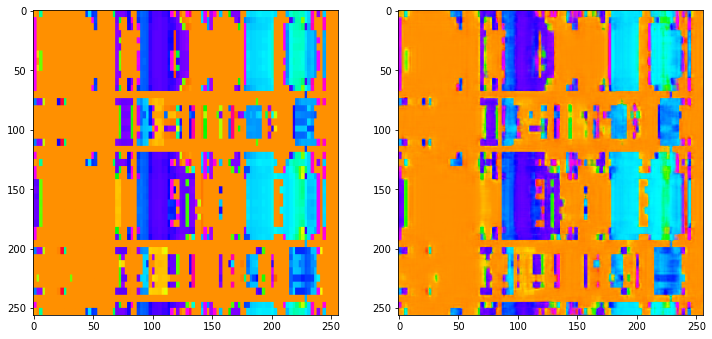

In [432]:
#Sanity check, view few images and corresponding reconstructions
image_number = random.randint(0, predicted.shape[0]-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(data_batch[0][image_number])
plt.subplot(122)
plt.imshow(predicted[image_number])
plt.show()

In [433]:
#Let us examine the reconstruction error between our validation data (good/normal images)
# and the anomaly images
validation_error = model.evaluate_generator(valid_generator)
anomaly_error = model.evaluate_generator(anomaly_generator)

print("Recon. error for the validation (normal) data is: ", validation_error)
print("Recon. error for the anomaly data is: ", anomaly_error)


/tmp/ipykernel_325463/506052696.py:3: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  validation_error = model.evaluate_generator(valid_generator)
/tmp/ipykernel_325463/506052696.py:4: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  anomaly_error = model.evaluate_generator(anomaly_generator)


Recon. error for the validation (normal) data is:  [0.010333670303225517, 0.010333670303225517]
Recon. error for the anomaly data is:  [0.01197440642863512, 0.01197440642863512]


In [6]:
#Let us extract (or build) the encoder network, with trained weights.
#This is used to get the compressed output (latent space) of the input image. 
#The compressed output is then used to calculate the KDE

encoder_model = Sequential()
encoder_model.add(Conv2D(64, (3, 3), activation='relu', padding='same',input_shape=(256, 256, 3), weights=model.layers[0].get_weights()))# input_shape=(256, 256, 3), weights=model.layers[0].get_weights())
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(32, (3, 3), activation='relu', padding='same', weights=model.layers[2].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.add(Conv2D(16, (3, 3), activation='relu', padding='same', weights=model.layers[4].get_weights()))
encoder_model.add(MaxPooling2D((2, 2), padding='same'))
encoder_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
encoder_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 128, 128, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 128, 128, 32)      18464     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 64, 64, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 64, 64, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 32, 32, 16)       

In [436]:
# Calculate KDE using sklearn
from sklearn.neighbors import KernelDensity

#Get encoded output of input images = Latent space
encoded_images = encoder_model.predict_generator(train_generator)

# Flatten the encoder output because KDE from sklearn takes 1D vectors as input
encoder_output_shape = encoder_model.output_shape #Here, we have 16x16x16
out_vector_shape = encoder_output_shape[1]*encoder_output_shape[2]*encoder_output_shape[3]

encoded_images_vector = [np.reshape(img, (out_vector_shape)) for img in encoded_images]

#Fit KDE to the image latent data
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_vector)


/tmp/ipykernel_325463/1984701846.py:5: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  encoded_images = encoder_model.predict_generator(train_generator)


In [440]:
#Calculate density and reconstruction error to find their means values for
#good and anomaly images. 
#We use these mean and sigma to set thresholds. 
def calc_density_and_recon_error(batch_images):
    
    density_list=[]
    recon_error_list=[]
    for im in range(0, batch_images.shape[0]-1):
        
        img  = batch_images[im]
        img = img[np.newaxis, :,:,:]
        encoded_img = encoder_model.predict([[img]]) # Create a compressed version of the image using the encoder
        encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] # Flatten the compressed image
        density = kde.score_samples(encoded_img)[0] # get a density score for the new image
        reconstruction = model.predict([[img]])
        reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
        density_list.append(density)
        recon_error_list.append(reconstruction_error)
        
    average_density = np.mean(np.array(density_list))  
    stdev_density = np.std(np.array(density_list)) 
    
    average_recon_error = np.mean(np.array(recon_error_list))  
    stdev_recon_error = np.std(np.array(recon_error_list)) 
    if density_list:
        print('minimum_density',min(density_list))
        print('maximum_density',max(density_list))

        print('minimum_recon', min(recon_error_list))
        print('maximum_recon', max(recon_error_list))
    return average_density, stdev_density, average_recon_error, stdev_recon_error


In [441]:
#Get average and std dev. of density and recon. error for deadlift and anomaly images. 
#For this let us generate a batch of images for each. 
norm =[]
anom =[]
for i in range(20):
    
    train_batch = valid_generator.next()[0]
    anomaly_batch = anomaly_generator.next()[0]

    deadlift_values = calc_density_and_recon_error(train_batch)
    anomaly_values = calc_density_and_recon_error(anomaly_batch)
    anom.append(anomaly_values)
    norm.append(deadlift_values)

1/1 [==============================] - 0s 17ms/step - loss: 0.0234 - mse: 0.0234
minimum_density -245802.68556385412
maximum_density -184515.58056282767
minimum_recon 0.012970279902219772
maximum_recon 0.023375865072011948
1/1 [==============================] - 0s 17ms/step - loss: 0.0259 - mse: 0.0259
minimum_density -387254.3344553413
maximum_density -261279.06891806689
minimum_recon 0.024761028587818146
maximum_recon 0.0286941509693861
1/1 [==============================] - 0s 17ms/step - loss: 0.0162 - mse: 0.0162
minimum_density -360143.49877016846
maximum_density -209831.39868459947
minimum_recon 0.015134129673242569
maximum_recon 0.01987549476325512
1/1 [==============================] - 0s 17ms/step - loss: 0.0264 - mse: 0.0264
minimum_density -301352.34903838753
maximum_density -211503.65338116756
minimum_recon 0.010816697031259537
maximum_recon 0.026406146585941315
1/1 [==============================] - 0s 17ms/step - loss: 0.0251 - mse: 0.0251
minimum_density -263711.3348698

/usr/local/lib/python3.9/dist-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/usr/local/lib/python3.9/dist-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


1/1 [==============================] - 0s 18ms/step - loss: 0.0400 - mse: 0.0400
minimum_density -348138.21678094426
maximum_density -302203.0103066309
minimum_recon 0.019321024417877197
maximum_recon 0.03999108821153641
1/1 [==============================] - 0s 18ms/step - loss: 0.0186 - mse: 0.0186
minimum_density -252294.850945789
maximum_density -184515.58056282767
minimum_recon 0.012970279902219772
maximum_recon 0.018601974472403526
1/1 [==============================] - 0s 17ms/step - loss: 1.3281e-05 - mse: 1.3281e-05
minimum_density -347754.33149522584
maximum_density 11307.848524470217
minimum_recon 1.3281312021717895e-05
maximum_recon 0.020461272448301315
1/1 [==============================] - 0s 17ms/step - loss: 0.0197 - mse: 0.0197
minimum_density -272252.6660291538
maximum_density -201266.2238442665
minimum_recon 0.016949109733104706
maximum_recon 0.025135410949587822
1/1 [==============================] - 0s 18ms/step - loss: 0.0127 - mse: 0.0127
minimum_density -331440.

In [442]:
np.mean([i[0] for i in norm])

-228948.7413536887

In [443]:
np.mean([i[-2] for i in norm])

0.018188284508263076

In [444]:
np.mean([i[-1] for i in norm])

0.0030919848807593265

In [445]:
np.mean([i[1] for i in norm])

36464.14213423275

In [446]:
np.mean([i[0] for i in anom if str(i[0])!='nan'])

-300820.30254190875

In [447]:
np.mean([i[1] for i in anom if str(i[0])!='nan'])

45017.31193499281

In [448]:
np.mean([i[-2] for i in anom if str(i[0])!='nan'])

0.021145345388280827

In [449]:
np.mean([i[-1] for i in anom if str(i[0])!='nan'])

0.006699064135878653

In [486]:
#Now, input unknown images and sort as Good or Anomaly
def check_anomaly(img_path):
    density_threshold = -250000 #Set this value based on the above exercise
    reconstruction_error_threshold = 0.032# Set this value based on the above exercise
    img  = Image.open(img_path)
    img = np.array(img.resize((256,256)))
    plt.imshow(img)
    img = img / 255.
    img = img[np.newaxis, :,:,:]
    encoded_img = encoder_model.predict([[img]]) 
    encoded_img = [np.reshape(img, (out_vector_shape)) for img in encoded_img] 
    density = kde.score_samples(encoded_img)[0] 

    reconstruction = model.predict([[img]])
    reconstruction_error = model.evaluate([reconstruction],[[img]], batch_size = 1)[0]
    print('reconstruction_error: ', reconstruction_error)
    print('density: ', density)
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        print("The image is an anomaly")
        
    else:
        print("The image is NOT an anomaly")

In [487]:
#Load a couple of test images and verify whether they are reported as anomalies.
import glob
anomaly_file_paths = glob.glob('../Data/Orientation/anomaly/anomaly/*')
deadlift_file_paths = glob.glob('../Data/Orientation/Data/valid/deadlift/*')


1/1 [==============================] - 0s 18ms/step - loss: 0.0362 - mse: 0.0362
reconstruction_error:  0.036190010607242584
density:  -257960.31033580253
The image is an anomaly


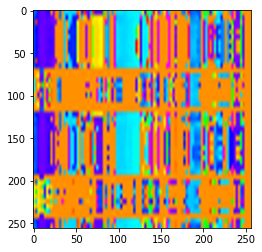

In [488]:
#Anomaly image verification
num=random.randint(0,len(anomaly_file_paths)-1)
check_anomaly(anomaly_file_paths[num])

1/1 [==============================] - 0s 18ms/step - loss: 0.0216 - mse: 0.0216
reconstruction_error:  0.02162356674671173
density:  -245219.7886366541
The image is NOT an anomaly


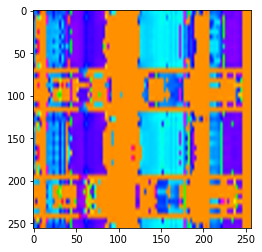

In [489]:

#Good/normal image verification
num=random.randint(0,len(deadlift_file_paths)-1)
check_anomaly(deadlift_file_paths[num])

In [504]:
# encoder_model.save('encoder500epoch.keras')

In [503]:
# model.save('autoencoder500epoch.keras')